Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; 

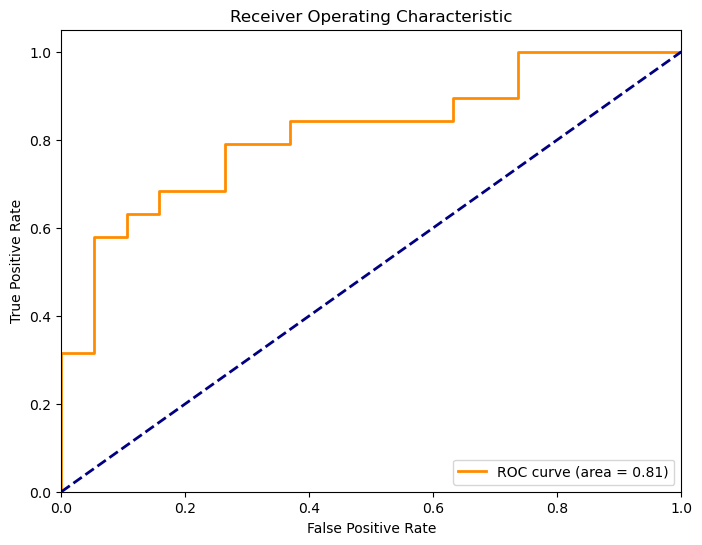

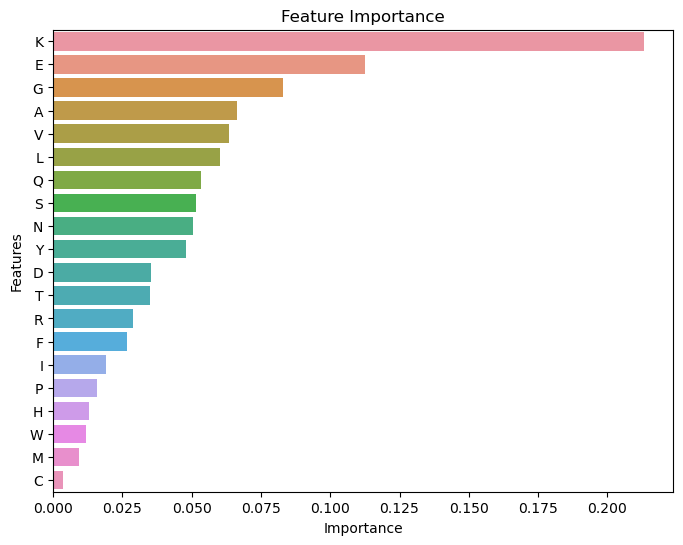

In [2]:
# Install required packages
!pip install biopython
!pip install lazypredict
!pip install -U scikit-learn

import pandas as pd
import numpy as np
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.SeqUtils import ProtParamData
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, matthews_corrcoef, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from lazypredict.Supervised import LazyClassifier
from sklearn.preprocessing import LabelEncoder

# Function to calculate Amino Acid Composition (AAC)
def aac(input_file):
    sequences = []
    with open(input_file, 'r') as file:
        lines = file.readlines()
        sequences = [line.strip() for line in lines if not line.startswith(">")]

    aac_list = []
    for sequence in sequences:
        protein = ProteinAnalysis(sequence)
        composition = protein.get_amino_acids_percent()
        aac_list.append(composition)

    df = pd.DataFrame(aac_list)
    return df

# Function to calculate Dipeptide Composition (DPC)
def dpc(input_file):
    sequences = []
    with open(input_file, 'r') as file:
        lines = file.readlines()
        sequences = [line.strip() for line in lines if not line.startswith(">")]

    dpc_list = []
    for sequence in sequences:
        protein = ProteinAnalysis(sequence)
        protein_data = ProtParamData.kd
        dipeptide_composition = {}
        for aa1 in ProtParamData.kd:
            for aa2 in ProtParamData.kd:
                dipeptide = aa1 + aa2
                dipeptide_count = sequence.count(dipeptide)
                dipeptide_composition[dipeptide] = dipeptide_count / len(sequence)

        dpc_list.append(dipeptide_composition)

    df = pd.DataFrame(dpc_list)
    return df
# Load dataset
pos = '/kaggle/input/Testdataset/test_set/test_po.fasta'
neg = '/kaggle/input/Testdataset/test_set/test_ne.fasta'

feature_combined = feature_calc(pos, neg, aac)

# Assign features to X and class labels to y
X = feature_combined.drop('class', axis=1)
y = feature_combined['class'].replace({"positive": 1, "negative": 0})

# Data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Hyperparameter tuning for the random forest model
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:")
print(best_params)

# Use the best hyperparameters to build the final random forest model
rf_final = RandomForestClassifier(**best_params, random_state=42)
rf_final.fit(X_train, y_train)

# Make predictions on the test set
y_test_pred = rf_final.predict(X_test)

# Simplest and quickest way to obtain the model performance (Accuracy)
accuracy = rf_final.score(X_test, y_test)
print("Accuracy of the final Random Forest model:", accuracy)

# Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test, y_test_pred)
print("MCC of the final Random Forest model:", mcc)

# Classification report
model_report = classification_report(y_test, y_test_pred, target_names=['positive', 'negative'])
print("Classification Report:\n", model_report)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", conf_matrix)

# ROC curve
y_test_prob = rf_final.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Feature importance
importance = pd.Series(rf_final.feature_importances_, index=X.columns)
importance_sorted = importance.sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=importance_sorted.values, y=importance_sorted.index)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()
